## Avaliação em holdouts - Amazon Digital Music


In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Digital Music
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


### RSISGD

In [4]:
buckets = joblib.load('output/amazon_digmusic_dump/sample_buckets.joblib')
holdouts = joblib.load('output/amazon_digmusic_dump/sample_holdouts.joblib')

Hyperparameters

In [5]:
# importa dataset 'books playlists'
data = pd.read_csv('output/amazon_digmusic_dump/sampled_amazon_digmusic.csv')
dataset_name = 'Amazon_Kindle'
user_col = 'user_id'
item_col = 'item_id'

In [6]:
%%time
import itertools
from eval_implicit import EvalPrequential
def grid_search(model, stream, random_seed = 10, interleaved=10):    
#     num_factors = [100, 150, 200]
#     num_iter = [2, 5, 8]
#     learn_rate = [0.1, 0.25, 0.5]
#     regularization = [0.3, 0.4, 0.5]
#     num_nodes = [4, 8, 16]
#     grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
#     grid = list(itertools.product(*grid))
    grid = [1, 2, 5, 10] # ra length
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = (100, 5, 0.5, 0.3, 4) #hp, same hp as ISGD
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed, ra_length = hp)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results    

# OPTIONAL FOR NOW
prop = 0.05
hp_sample = data.iloc[:round( data.shape[0]*prop )]
stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
grid, results = grid_search(model=RSISGD, stream=stream, random_seed=10, interleaved=1 )
len(grid), len(results), max(results) # (243, 243, 0.003461128860489883)

0.0 %
25.0 %
50.0 %
75.0 %
CPU times: user 54.3 s, sys: 2min 24s, total: 3min 18s
Wall time: 57.6 s


(4, 4, 0.002161383285302594)

In [8]:
print ( grid[ np.argmax( results ) ] )
ra_length = grid[ np.argmax( results ) ]
num_factors, num_iter, learn_rate, regularization, num_nodes = (100, 5, 0.5, 0.3, 4) # grid[ np.argmax( results ) ] # (100, 5, 0.5, 0.3, 4)

# define hyperparameters (SAME AS LASTFM) ????
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

1


In [10]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = RSISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10, ra_length=ra_length)

In [11]:
%%time
# 30min 25s
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 23.4 µs


In [12]:
%%time
# 1h 23min 37s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 410
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 962
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 346
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: user 39min 17s, sys: 1h 27min 12s, total: 2h 6min 30s
Wall time: 45min 39s


(None,)

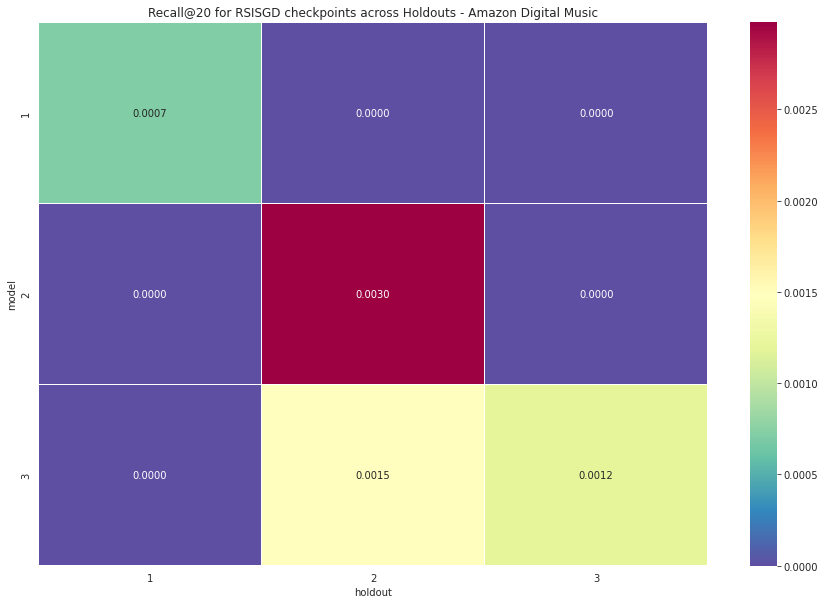

In [13]:
rm = eval.results_matrix
df = pd.DataFrame(rm)

recall_heatmap(df,
    round_point=4,
    title='Recall@20 for RSISGD checkpoints across Holdouts - Amazon Digital Music'),
#     filepath='images/heatmaps/amazon_digmusic_dump/sample_amazon_digital_music month_bucket RSISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

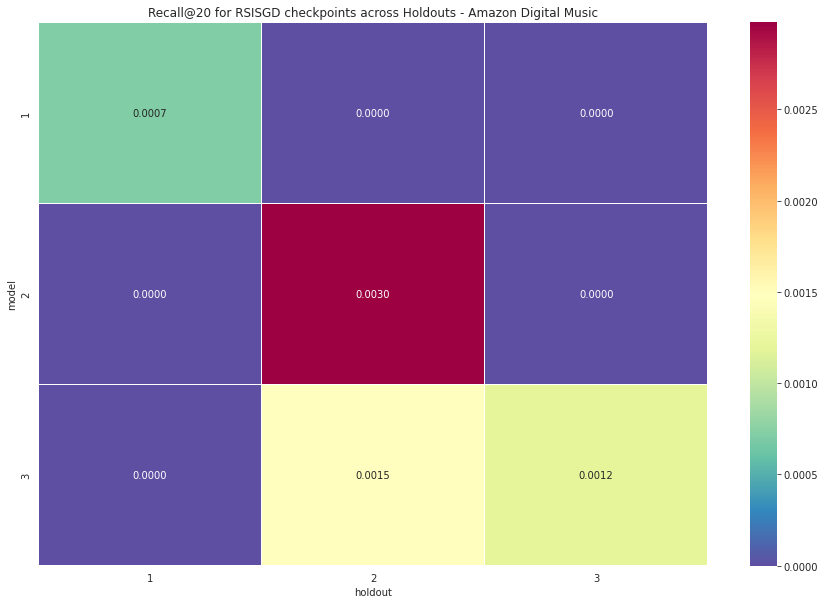

In [14]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/amazon_digmusic_dump/sample_amazon_digital_music month_bucket RSISGD results.csv', index=False)

recall_heatmap(df,
    round_point=4,
    title='Recall@20 for RSISGD checkpoints across Holdouts - Amazon Digital Music',
    filepath='images/heatmaps/amazon_digmusic_dump/sample_amazon_digital_music month_bucket RSISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [15]:
arecall = avg_recall(df)
arecall

0.001630350285677992

In [16]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.0007158196134574087, -0.0011019574257763232], -0.000908888519616866)

In [17]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0

In [18]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.0007158196134574087, -0.0011019574257763232], -0.000908888519616866)

In [19]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazon_digmusic_dump/sample_amazon_digmusic month_bucket RSISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazon_digmusic_dump/sample_amazon_digmusic month_bucket RSISGD eval time.joblib')

['output/amazon_digmusic_dump/sample_amazon_digmusic month_bucket RSISGD eval time.joblib']

In [14]:
import pandas as pd
import numpy as np

def avg_recall(results_matrix):
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Díaz-Rodriguez et al. 2018
    diff = []
    n_checkpoints = results_matrix.shape[0]
    for i in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        for j in range(i):
            Rij = results_matrix.iloc[i,j] # get models performances' on previous holdouts
            Rjj = results_matrix.iloc[j,j] # get models performances' on their closest holdouts (diagonal)
            # print(Rij, Rjj)
            diff.append( Rij - Rjj ) # future models performances' - performances' of models closest to holdouts (diagonal)
            # print(diff)
    BWT = sum(diff) / ( n_checkpoints*(n_checkpoints-1) / 2 ) # store average BWT for model
    return BWT, diff # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

In [15]:
df = pd.read_csv('output/amazon_digmusic_dump/sample_amazon_digital_music month_bucket RSISGD results.csv')

In [16]:
avg_recall(df).round(5)

0.00163

In [17]:
BWT, diff = compute_BWT(df)
print( BWT.round(6) )

-0.000973


In [18]:
compute_FWT(df)

0.0